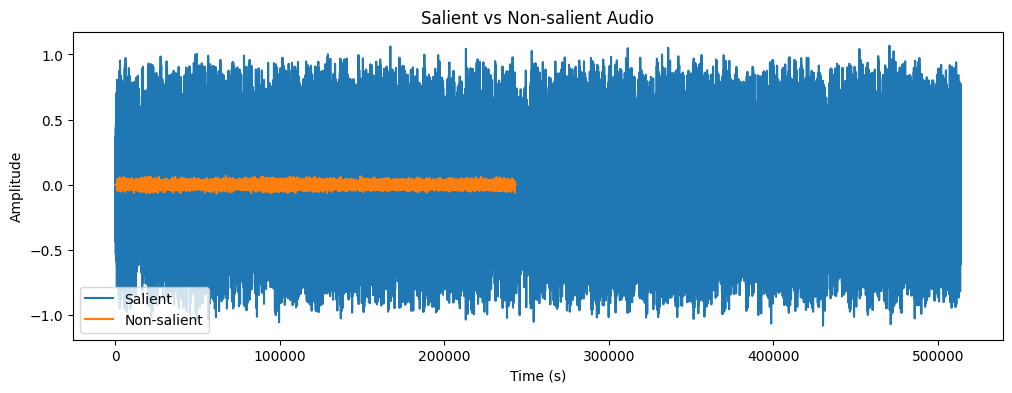

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa  

nonSalientFile = r"SaliencySoundTest/low-saliency-background.mp3"
salientFile = r"SaliencySoundTest/second-warning-high-saliency.mp3"


non_salient_audio, samplingRateNonSalient = librosa.load(nonSalientFile, sr = None)
salient_audio, samplingRateSalient = librosa.load(salientFile, sr = None)

# Visualize
plt.figure(figsize=(12,4))
plt.plot(range(0, len(salient_audio), 1), salient_audio, label="Salient")
plt.plot(range(0, len(non_salient_audio), 1), non_salient_audio, label="Non-salient")
# plt.plot(t, salient_audio, label="Salient", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Salient vs Non-salient Audio")
plt.legend()
plt.show()


In [13]:
def processWave(type, wave, sampleRate):
    windowSize = 2048
    hopSize = 100
    
    # converts this to a Short-Time Fourier Transform. Tells you how much eergy has at each frequency over time.
    # does this by going through windows. Length of each window defined by n_fft. Then, shifts window to right by length
    # hop length. at each window, computes how much of each frequency is present.
    # final value is 2D array of rows being each frequency, columns being time (which is now the windows), so value being amplitude/energy for that time and frequency
    stftWave = np.abs(librosa.stft(wave, n_fft=windowSize, hop_length=hopSize))
    # when we get the mel, that just converts all the frequencies to 128 possible onces, which are moreso frequencies humans can hear. So compressing
    # the frequencies from a large number of frequencies to a smaller number, in this case n_mels amount
    mel = librosa.feature.melspectrogram(S = stftWave, sr= sampleRate, n_mels = 128)
    # converts from power scaling of audio to decibel scaling, cause humans perceive in moreso logarithm of audio (so higher sounds kinda taper off to us)
    logMel = librosa.power_to_db(mel, ref=np.max)

    # gets overall frame energy, including amplitude
    frameEnergy = np.sqrt(np.mean(logMel ** 2, axis=0))
    # gets the contrast in energy between frequencies within a specific frequency band, so where some frequencies bands may have parts of high energy frequencies, while other parts are low energy
    contrast = librosa.feature.spectral_contrast(S = stftWave, sr=sampleRate)
    # combines the difference frequency bands to get a average contrast for that time frame
    contrast = np.mean(contrast, axis=0)
    # basically gets how much the sound chagnes over time. Does this by getting differnece over time fimes with np.diff, squaring that value, and getting its sum
    temporal_novelty = np.sum(np.diff(logMel, axis=1) ** 2, axis=0)
    # do this to add an extra value cause rn, the length is T - 1, since you're getting difference between frames. So add 1 to get it to T length
    temporal_novelty = np.insert(temporal_novelty, 0, 0)

    # standard normalization
    frameEnergyNorm = frameEnergy / np.max(frameEnergy)
    contrastNorm = contrast / np.max(contrast)
    temporal_novelty_norm = temporal_novelty / np.max(temporal_novelty)

    # gets it for the overall time
    finalSaliency = 0.5 * frameEnergyNorm + 0.3 * contrastNorm + 0.2 * temporal_novelty_norm

    secondsIn = 6.5
    # divide by hoSize as first secondIn * sr gets the specific sample we want. Dividing by hopSize tells us how many windows to traverse
    # to get to that sample, as say if it's less than hopSize, its in the window at index 0, if it's slightly more, it's in the window at index 1, etc
    index = int(secondsIn * sampleRate / hopSize)


    print(f"For type of wave {type}, saliency was {finalSaliency[index]}")



processWave("Salient", salient_audio, samplingRateSalient)
processWave("Non-Salient", non_salient_audio, samplingRateNonSalient)



For type of wave Salient, saliency was 0.6612560022267049
For type of wave Non-Salient, saliency was 0.512157459468701
